In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')
import tokamakTK

from tokamakTK import get_metrics_for_decreasing

import pydotplus
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


pd.set_option('display.max_columns', None)
path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"

sstyle = 'seaborn-v0_8-poster'
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
#DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


In [4]:
plasma_characteristics = ["Q95","BEIMHD","PREMAG",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI","PNBI"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 

features = plasma_characteristics + TOK_characteristics + ELM + \
           heating + impurities + power + temperatures + fast_particles

In [5]:
categorical_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

# 3 subsets to study
research_features = ['NEL','TAV','BT','RHOSTAR','NUSTAR','BETASTAR'] + categorical_features
entropy_low_MCL = ['WFFORM', 'RHOSTAR', 'DWDIA', 'BETASTAR', 'POHM', 'NEL', 'NUSTAR', 'PLTH'] + categorical_features
low_MLC = ['BEIMHD', 'BETASTAR', 'BT', 'DWDIA', 'ELMFREQ', 'IP', 'NEL', 'NESOL', 'NUSTAR', 
           'PECRH', 'PFLOSS', 'PICRH', 'POHM', 'PRAD', 'Q95', 'RHOSTAR', 'TIV', 'TORQ', 
           'WFFORM', 'WFICFORM', 'ZEFF', 'ZEFFNEO']
FEATURES = [research_features, entropy_low_MCL, low_MLC]

In [6]:
def split_clean_data(features, db5):
    DB5 = tokamakTK.clean_categorical_data(db5)
    # Needed to respectively clean each dtype
    num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
    cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()
    data_num = DB5[num_features+["TOK","DATE"]]
    data_cat = DB5[cat_features]
    data_num = tokamakTK.clean_numerical_data(data_num)
    data_ = pd.concat([data_num,
                      (pd.concat([
                           DB5[["label"]], 
                           tokamakTK.encode_categorical_ohe(data_cat)
                          ], axis=1)
                      )],
                      axis=1)
    X = data_.drop("label", axis=1)
    y = data_["label"]
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)
    return X_train, X_test, y_train, y_test

def define_model(X_train, y_train, model_="RF"):
    gp = GaussianProcessClassifier(random_state=71, n_jobs=-1)
    if model_ == "RF":
        model = RandomForestClassifier(min_samples_split=2,  
                                min_samples_leaf=1,
                                min_impurity_decrease=0.0007,
                                n_estimators = 90,
                                max_depth = 23,
                                criterion='entropy',
                                max_features=None,
                                n_jobs=-1,
                                random_state=71
                               )
    else:
        model = GaussianProcessClassifier(random_state=71, n_jobs=-1)
    model.fit(X_train, y_train)
    return model

def get_predictions(model, X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

def get_PRCs(results, label_pos=["lower left"]*3):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5.7))
    for i, result in enumerate(results):
        axs[i].plot(result[1], result[0], marker='.', label='Research', c="#A84547")
        axs[i].grid(alpha=0.5)
        axs[i].legend(loc=label_pos[i])
    axs[0].set_ylabel("Precision\n")
    axs[1].set_xlabel("\nRecall")
    plt.show()

In [7]:
SPLIT_DATA = [split_clean_data(f, db5=DB5) for f in FEATURES]
GaussianP  = [define_model(split_data[0], split_data[2], model_="GP") for split_data in SPLIT_DATA]
RdForests  = [define_model(split_data[0], split_data[2], model_="RF") for split_data in SPLIT_DATA]

In [8]:
GaussianP_preds = [get_predictions(GaussianP[i], SPLIT_DATA[i][1]) for i in range(3)]
RdForests_preds = [get_predictions(RdForests[i], SPLIT_DATA[i][1]) for i in range(3)]

In [9]:
#precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
GP_PRCs = [precision_recall_curve(SPLIT_DATA[i][3], GaussianP_preds[i][:,1]) for i in range(3)]
RF_PRCs = [precision_recall_curve(SPLIT_DATA[i][3], RdForests_preds[i][:,1]) for i in range(3)]

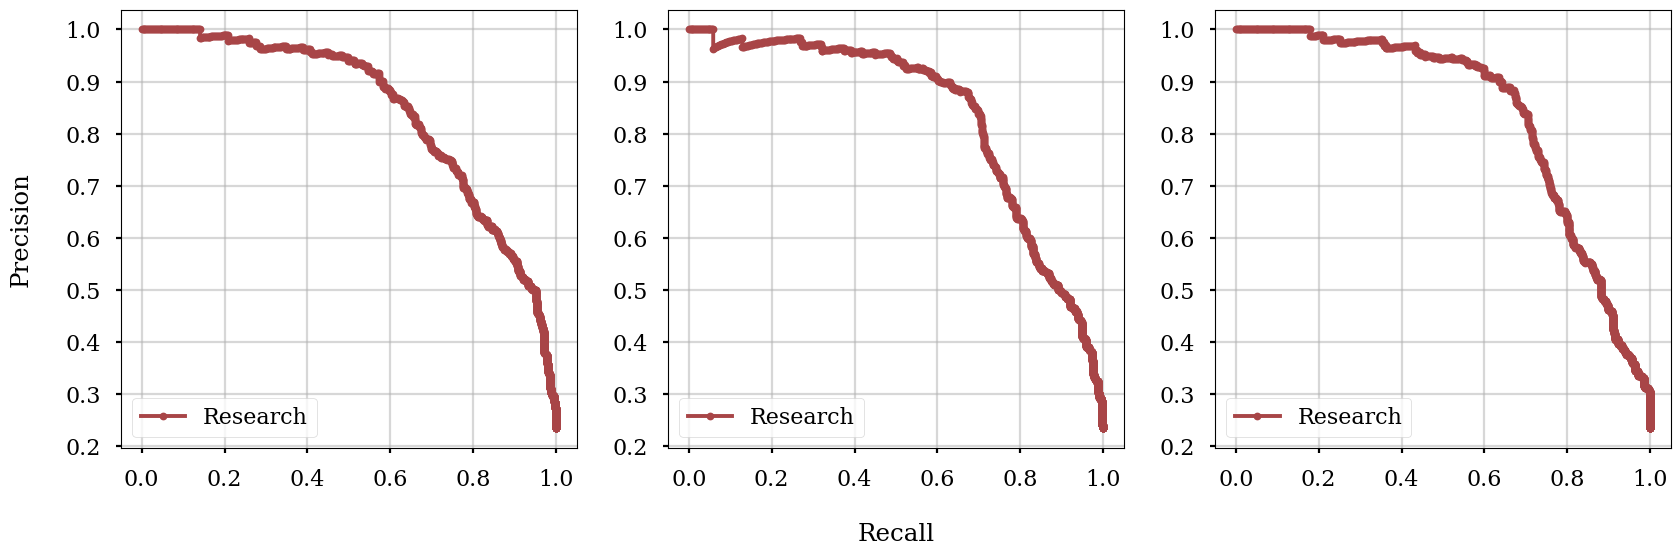

In [10]:
get_PRCs(GP_PRCs)

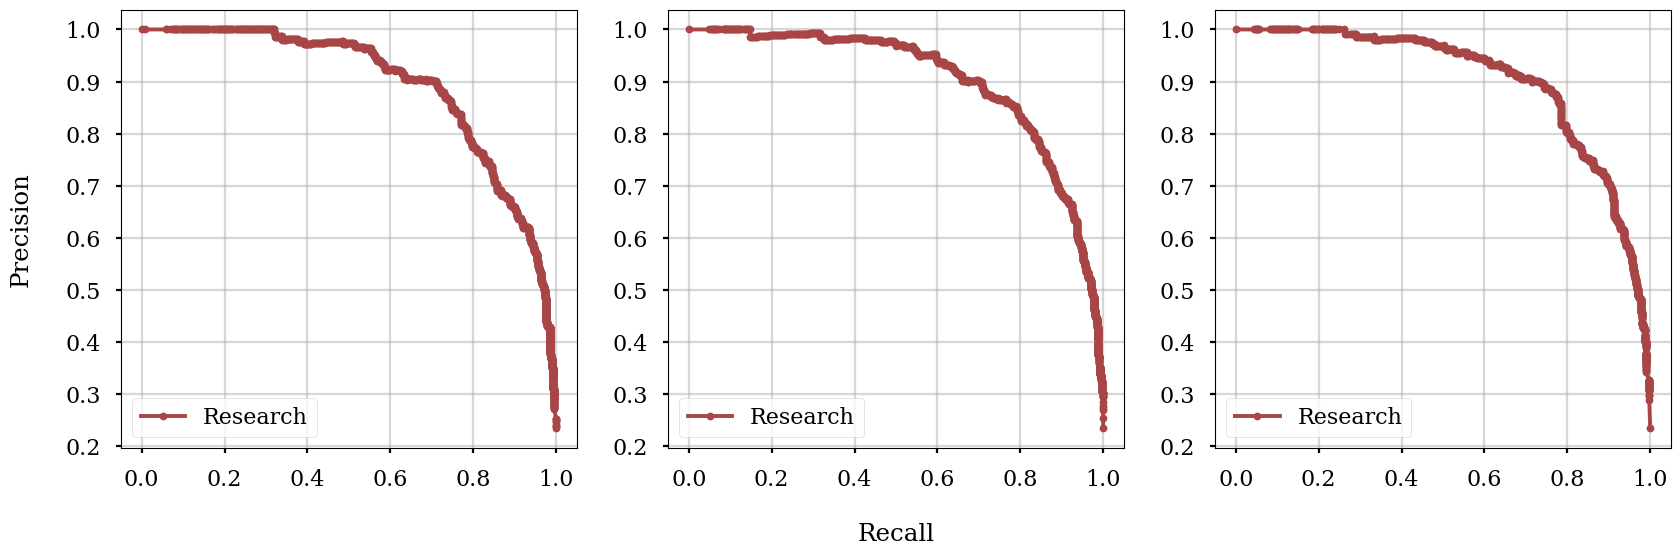

In [11]:
get_PRCs(RF_PRCs)